## CartPole with PPO

This is a demo notebook for training RL algorithms for a simple environment.

Libraries:
- [Gymnasium](https://gymnasium.farama.org/environments/classic_control/cart_pole/)
- [Stable-Baselines 3](https://stable-baselines3.readthedocs.io/en/master/index.html)

Demonstrates:
- Creating environment
- Training RL algorithms
- Displaying stats of training (including using Tensorboard)
- Evaluating policy
- Running the trained agent and producing video
- Submitting the agent to Hugging Face, loading the agent from Hugging Face

In [1]:
# Forcefully remove the old 'gym' package to avoid conflicts in Colab
%pip uninstall -y gym
%pip install -qr https://raw.githubusercontent.com/anton-dergunov/hugging-face-deep-rl/main/requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common import results_plotter
from huggingface_hub import HfApi, create_repo, notebook_login, hf_hub_download
import cv2
from IPython.display import Video
import matplotlib.pyplot as plt
from pathlib import Path
import hashlib
import imageio
import os
import json
import tempfile

In [3]:
import warnings

# This filter handles the "pkg_resources is deprecated" warning from Pygame
warnings.filterwarnings("ignore", category=DeprecationWarning, module='pygame')
warnings.filterwarnings("ignore", category=UserWarning, module="pygame")

# This filter handles all the "Deprecated call to `pkg_resources.declare_namespace`" warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module='pkg_resources')

In [4]:
MODEL_PATH = "models/ppo_cartpole.zip"
VIDEO_PATH = "videos/ppo_cartpole.mp4"
LOGS_PATH = "logs/ppo_cartpole"

os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
os.makedirs(os.path.dirname(VIDEO_PATH), exist_ok=True)
os.makedirs(LOGS_PATH, exist_ok=True)

In [ ]:
ENV_ID = "CartPole-v1"
REPO_ID = "AntonDergunov/CartPole_PPO"

### Create Environment

"[CartPole-v1](https://gymnasium.farama.org/environments/classic_control/cart_pole/)" is a simple classic control task.

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

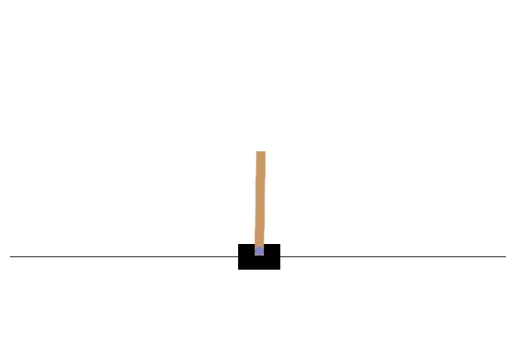

In [6]:
def show_environment():
    env = gym.make(ENV_ID, render_mode="rgb_array")

    env.reset()
    frame = env.render()

    plt.imshow(frame)
    plt.axis("off")
    plt.show()

    env.close()

show_environment()

We create a vectorized environment (parallel environments; 4 copies of the environment in our case) for training RL algorithms implemented in [Stable-Baselines 3](https://stable-baselines3.readthedocs.io/en/master/index.html)

In [ ]:
vec_env = make_vec_env(ENV_ID, n_envs=4, monitor_dir=LOGS_PATH)

The shape of the observation space is `(4,)` with the values corresponding to:

| Num | Observation           |
|-----|-----------------------|
| 0   | Cart X position       |
| 1   | Cart velocity         |
| 2   | Pole angle in radians |
| 3   | Pole angular velocity |

In [8]:
print("Observation Space Shape", vec_env.observation_space.shape)
print("Sample observation", vec_env.observation_space.sample())  # Get a random observation

Observation Space Shape (4,)
Sample observation [ 4.226511   -2.4218001  -0.31144124 -0.01919652]


The shape of the action space is `(1,)`. This number can take the following values:
- 0: push the cart to the left
- 1: push the cart to the right

The goal is to keep the pole upright for as long as possible. A reward of `+1` is given for every step taken.

The episode ends when:
- Pole angle > ±12°
- Cart position is greater than ±2.4
- Episode length > 500 (truncation)

In [9]:
print("Action Space Shape", vec_env.action_space.n)
print("Action Space Sample", vec_env.action_space.sample())  # Take a random action

Action Space Shape 2
Action Space Sample 1


### Define & Train PPO Agent

[PPO Algorithm](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)

Training statistics:

- `rollout`:
    - `ep_len_mean`: Average episode length (steps before pole falls)
    - `ep_len_mean`: Average reward (same as length here)
- `time`:
    - `fps`: Training speed (frames per second)
    - `iterations`: Number of iterations?
    - `time_elapsed`: Time in seconds since the beginning of training
    - `total_timesteps`: Total number of timesteps. PPO collects in chunks of 8192 timesteps (with 4 envs × ~2048 steps)
- `train`:
    - `approx_kl`: KL divergence between new and old policy
    - `clip_fraction`: % of updates where PPO clipped gradients
    - `clip_range`: Value of clipping factor?
    - `entropy_loss`: Policy entropy (exploration). Lower → more deterministic.
    - `explained_variance`: How well value function predicts returns. 1 = perfect
    - `learning_rate`: Current learning rate value
    - `loss`: Current total loss value
    - `n_updates`: Number of gradient updates applied so far?
    - `policy_gradient_loss`: Current value of the policy gradient loss (its value does not have much meaning)
    - `value_loss`: Current value for the value function loss

Details: [Explanation of logger output](https://stable-baselines3.readthedocs.io/en/master/common/logger.html#explanation-of-logger-output)

In [ ]:
# Initialize PPO model with TensorBoard logging
model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    device="cpu",
    tensorboard_log=LOGS_PATH   # TensorBoard will write here
)

# Train the agent
model.learn(total_timesteps=25_000)

# Save the trained model
model.save(MODEL_PATH)

Using cpu device


/Users/anton/Dropbox/src/hugging-face-deep-rl/.venv/lib/python3.12/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


Logging to logs/ppo_cartpole/PPO_8
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.7     |
|    ep_rew_mean     | 26.7     |
| time/              |          |
|    fps             | 18801    |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 32.6        |
|    ep_rew_mean          | 32.6        |
| time/                   |             |
|    fps                  | 7008        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.013898477 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.682      |
|    explained_variance   | -0.0026  

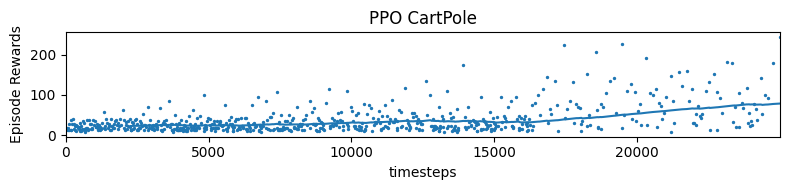

In [11]:
# Plot results using Stable-Baselines3 helper
plot_results([LOGS_PATH], 25_000, results_plotter.X_TIMESTEPS, "PPO CartPole")
plt.show()

In [12]:
ENABLE_TENSORBOARD = False

if ENABLE_TENSORBOARD:
    %load_ext tensorboard
    %tensorboard --logdir ./logs/ppo_cartpole

### Load Trained Model

In [13]:
# Load the saved model
model = PPO.load(MODEL_PATH, device="cpu")

### Evaluate Policy

`n_eval_episodes` is the number of independent full episodes to run when evaluating the trained agent.

In [14]:
def evaluate_model(model, env_id, n_eval_episodes=10):
    env = Monitor(gym.make(env_id))
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, deterministic=True)
    env.close()
    return {
        "mean_reward": mean_reward,
        "std_reward": std_reward,
        "n_eval_episodes": n_eval_episodes
    }

In [15]:
metrics = evaluate_model(model, ENV_ID)
print(metrics)

{'mean_reward': np.float64(438.6), 'std_reward': np.float64(87.14034656805079), 'n_eval_episodes': 10}


### Run Trained Agent

In [16]:
def record_cartpole_video(model, video_path, steps=1000):
    # Set the video driver to a dummy one to prevent window creation
    os.environ["SDL_VIDEODRIVER"] = "dummy"
    
    # Create env with video recording enabled
    env = gym.make(ENV_ID, render_mode="rgb_array")
    
    try:
        frames = []
        obs, info = env.reset()
        episode, step = 0, 0

        for _ in range(steps):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            
            # Render the frame from the environment
            frame = env.render()

            # --- Overlay text (small, anti-aliased) ---
            cv2.putText(frame, f"Ep: {episode}", (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(frame, f"Step: {step}", (10, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

            frames.append(frame)
            step += 1

            if terminated or truncated:
                episode += 1
                step = 0
                obs, info = env.reset()
        
        # Save the collected frames to a single video file
        os.makedirs(os.path.dirname(video_path), exist_ok=True)
        imageio.mimsave(video_path, frames, fps=30, macro_block_size=None)
        print(f"Saved video to {video_path}")

    finally:
        # Ensure the environment is closed to release all resources
        env.close()

In [17]:
# Save to video
record_cartpole_video(model, video_path=VIDEO_PATH, steps=1000)

Saved video to videos/ppo_cartpole.mp4


In [18]:
Video(VIDEO_PATH, embed=True)

### Hugging Face: Store Credentials

Create and manage tokens on [Hugging Face settings page](https://huggingface.co/settings/tokens).
Make sure to use the token with write role!

Enable the cell below to store the login details when running first time.

In [19]:
ENABLE_HF_LOGIN = False

if ENABLE_HF_LOGIN:
    # Store Hugging Face token
    notebook_login()

    # Remember login credentials on disk
    !git config --global credential.helper store

### Hugging Face: Upload the Model

There is a library `huggingface_sb3` for uploading and downloading SB3 models to/from Hugging Face portal, but at the moment there are [some bugs](https://github.com/huggingface/huggingface_sb3/pull/47), so the code below implements this from scratch.

See details for [model cards](https://huggingface.co/docs/hub/model-cards).

In [ ]:
def generate_readme(repo_name, env_id, algo, metrics):
    yaml_metadata = f"""---
library_name: stable-baselines3
tags:
- reinforcement-learning
- deep-reinforcement-learning
- sb3
- {env_id}
model-index:
- name: {repo_name}
  results:
  - task:
      type: reinforcement-learning
      name: Reinforcement Learning
    dataset:
      name: {env_id}
      type: gym
    metrics:
    - type: mean_reward
      value: {metrics['mean_reward']:.2f}
      name: Mean Reward
    - type: std_reward
      value: {metrics['std_reward']:.2f}
      name: Std Reward
---
"""

    readme = f"""{yaml_metadata}

# {repo_name}

This is a reinforcement learning agent trained with **{algo}** on **{env_id}** using [Stable-Baselines3](https://github.com/DLR-RM/stable-baselines3).

## Usage

```python
import gymnasium as gym
from stable_baselines3 import PPO
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(repo_id="{repo_name}", filename="model.zip")
model = PPO.load(model_path, device="cpu")

env = gym.make("{ENV_ID}")
obs, info = env.reset()

for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        obs, info = env.reset()
```
"""

    return readme

In [21]:
def upload_sb3_model(model, repo_id, model_name, model_architecture, env_id,
                     metrics, commit_message="Upload SB3 model", video_path=None):
    api = HfApi()

    def upload_file(path_or_fileobj, path_in_repo, repo_id, commit_message):
        print(f"Uploading {path_in_repo}...")
        api.upload_file(
            path_or_fileobj=path_or_fileobj,
            path_in_repo=path_in_repo,
            repo_id=repo_id,
            commit_message=commit_message
        )

    with tempfile.TemporaryDirectory() as tmpdir:
        tmpdir = Path(os.path.abspath(tmpdir))

        # 1. Save model
        model_path = tmpdir / "model.zip"
        print(f"Saving the model to {model_path}...")
        model.save(model_path)

        # Output the size and hash of the saved model
        model_size = os.path.getsize(model_path)
        with open(model_path, "rb") as f:
            model_hash = hashlib.sha256(f.read()).hexdigest()
        print(f"Model size: {model_size / 1024:.2f} KB")
        print(f"Model SHA256: {model_hash}")

        # Try loading the file we just created as a verification step
        try:
            PPO.load(model_path, device="cpu")
        except Exception as e:
            print(f"❌ Verification failed. The saved file is corrupted: {e}")
            # Do not proceed if verification fails
            raise

        # 2. Create metadata
        metadata = {
            "model_name": model_name,
            "model_architecture": model_architecture,
            "env_id": env_id,
        }
        metadata_path = tmpdir / "metadata.json"
        with open(metadata_path, "w") as f:
            json.dump(metadata, f)

        # 3. Create README (model card)
        readme_path = tmpdir / "README.md"
        readme_text = generate_readme(repo_id, env_id, model_architecture, metrics)
        with open(readme_path, "w") as f:
            f.write(readme_text)

        # 4. Create repo if missing
        try:
            create_repo(repo_id, exist_ok=True)
        except Exception as e:
            print(f"Repo already exists or could not be created: {e}")

        # 5. Upload all files
        for file in [model_path, metadata_path, readme_path]:
            upload_file(
                path_or_fileobj=file,
                path_in_repo=os.path.basename(file),
                repo_id=repo_id,
                commit_message=commit_message,
            )

        # 6. Upload video separately
        if video_path:
            upload_file(
                path_or_fileobj=video_path,
                path_in_repo=f"replay.mp4",
                repo_id=repo_id,
                commit_message="Add demo video"
            )

    print(f"\n✅ Upload complete! View the model at:")
    print(f"https://huggingface.co/{repo_id}")

In [22]:
upload_sb3_model(
    model=model,
    repo_id=REPO_ID,
    model_name="CartPole_PPO",
    model_architecture="PPO",
    env_id=ENV_ID,
    metrics=metrics,
    video_path=VIDEO_PATH
)

Saving the model to /var/folders/f2/98g94n_x51l0zrxfnqp9s3wh0000gn/T/tmpulv244ed/model.zip...
Model size: 141.30 KB
Model SHA256: ef98275e86539740baf4689665510697e3785d75840539df187fb19b86269348
Uploading model.zip...


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...9s3wh0000gn/T/tmpulv244ed/model.zip: 100%|##########|  145kB /  145kB            

Uploading metadata.json...


No files have been modified since last commit. Skipping to prevent empty commit.


Uploading README.md...
Uploading replay.mp4...


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  videos/ppo_cartpole.mp4               : 100%|##########|  126kB /  126kB            


✅ Upload complete! View the model at:
https://huggingface.co/AntonDergunov/CartPole_PPO


### Hugging Face: Load the Model

TODO Also change the readme file to provide the updated instructions

In [23]:
def load_model_from_hub(repo_id, filename, device="cpu"):
    print(f"Loading model {filename} from repo {repo_id}...")
    model_path = hf_hub_download(repo_id=repo_id, filename=filename)
    
    model_size = os.path.getsize(model_path)
    with open(model_path, "rb") as f:
        model_hash = hashlib.sha256(f.read()).hexdigest()
    print(f"Model size: {model_size / 1024:.2f} KB")
    print(f"Model SHA256: {model_hash}")
    
    return PPO.load(model_path, device=device)

In [24]:
model = load_model_from_hub(
    repo_id=REPO_ID,
    filename="model.zip"
)

env = gym.make(ENV_ID)
obs, info = env.reset()
for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        obs, info = env.reset()

print("✅ Model loaded from Hugging Face and tested successfully!")

Loading model model.zip from repo AntonDergunov/CartPole_PPO...


model.zip:   0%|          | 0.00/145k [00:00<?, ?B/s]

Model size: 141.30 KB
Model SHA256: ef98275e86539740baf4689665510697e3785d75840539df187fb19b86269348
✅ Model loaded from Hugging Face and tested successfully!
